<a href="https://colab.research.google.com/github/Nidhitripathi316/Classroom-Booking-System/blob/master/image_caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [2]:
train_images_list = os.listdir('/content/drive/MyDrive/images')
sample_size = 30
train_images_list = train_images_list[:sample_size]

In [3]:
train_images_list

['1000092795.jpg',
 '10002456.jpg',
 '1000268201.jpg',
 '1000344755.jpg',
 '1000366164.jpg',
 '1000523639.jpg',
 '1000919630.jpg',
 '10010052.jpg',
 '1001465944.jpg',
 '1001545525.jpg',
 '1001573224.jpg',
 '1001633352.jpg',
 '1001773457.jpg',
 '1001896054.jpg',
 '100197432.jpg',
 '100207720.jpg',
 '1002674143.jpg',
 '1003163366.jpg',
 '1003420127.jpg',
 '1003428081.jpg',
 '100444898.jpg',
 '1005216151.jpg',
 '100577935.jpg',
 '1006452823.jpg',
 '100652400.jpg',
 '1007129816.jpg',
 '100716317.jpg',
 '1007205537.jpg',
 '1007320043.jpg',
 '100759042.jpg']

In [4]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import random

In [5]:
size = (256, 256)
num_channels = 3
train = np.array([None] * sample_size)
real_images = np.array([None] * sample_size)

In [6]:
real_images

array([None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None], dtype=object)

In [8]:
j = 0
for i in train_images_list:
    real_images[j] = np.array(plt.imread('/content/drive/MyDrive/images/' + i))
    train[j] = np.array(plt.imread('/content/drive/MyDrive/images/' + i))
    j += 1

In [9]:
j = 0
for i in train:
    train[j] = cv2.resize(i, size)
    train[j] = train[j].reshape(1, size[0], size[1], num_channels)
    j += 1

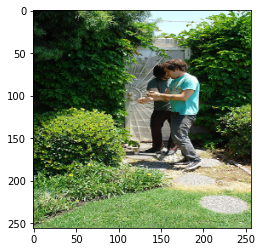

In [10]:
train = np.vstack(train[:])
plt.imshow(np.squeeze(train[0]))
plt.show()

In [11]:
import pandas as pd

In [12]:
train_captions = pd.read_csv('Book2.csv', delimiter='|')

In [13]:
train_captions

,image_name,comment_number,"comment,,,,,"
0,1000092795.jpg,0.0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1.0,"Two young ,,,,,"
2,1000092795.jpg,2.0,Two men in green shirts are standing in a yar...
3,1000092795.jpg,3.0,"A man in a blue shirt standing in a garden .,..."
4,1000092795.jpg,4.0,"Two friends enjoy time spent together .,,,,,"
...,...,...,...
744,1048710776.jpg,0.0,a couple of several people sitting on a ledge...
745,1048710776.jpg,1.0,Several young people sitting on a rail above ...
746,1048710776.jpg,2.0,A group of people sit on a wall at the beach ...
747,1048710776.jpg,3.0,"A group of teens sit on a wall by a beach .,,,,,"


In [14]:
def get_images_id(names):
    names = [int(x.split('_')[-1].split('.')[0]) for x in names]
    return names

In [15]:
train_captions.columns = ['image_name', 'comment_number', 'comment']

In [16]:
train_captions.columns

Index(['image_name', 'comment_number', 'comment'], dtype='object')

In [17]:
def images_map_caption(train_images_list, train_captions):
    caption = []
    for i in train_images_list:
        caption.append(train_captions[train_captions['image_name'] == i]['comment'].iat[0])
    return caption

In [18]:
captions = np.array(images_map_caption(train_images_list, train_captions))
print(captions.shape)

(30,)


In [19]:
import re

In [20]:
start_tag = '<s>'
end_tag = '<e>'

In [21]:
def get_vocab(captions):
    arr = []
    m = captions.shape[0]
    sentence = [None ] * m
    j  = 0
    for i in captions:
        i = re.sub(' +',' ',i)
        i = start_tag + ' ' + i + ' ' + end_tag
        sentence[j] = i.split()
        j += 1
        arr = arr + i.split()
    arr = list(set(arr))
    vocab_size = len(arr)
    j = 0
    fwd_dict = {}
    rev_dict = {}
    j = 0
    for i in arr:
        fwd_dict[i] = j
        rev_dict[j] = i
        j += 1
    return vocab_size, sentence, fwd_dict, rev_dict

In [22]:
vocab_size, sentences, fwd_dict, rev_dict = get_vocab(captions)

In [23]:
from scipy.sparse import csr_matrix
from scipy.sparse import vstack

In [24]:
m = len(sentences)
train_caption = [None] * m
i = 0
for sentence in sentences:
    cap_array = None
    for word in sentence:
        row = [0]
        col = [fwd_dict[word]]
        data = [1]
        if cap_array is None:
            cap_array = csr_matrix((data, (row, col)), shape=(1, vocab_size))
        else:
            cap_array = vstack((cap_array, csr_matrix((data, (row, col)), shape=(1, vocab_size))))
    train_caption[i] = cap_array
    i += 1

In [25]:
train_caption[0].shape

(19, 214)

In [26]:
def create_weights(shape, suffix):
    return tf.Variable(tf.random.truncated_normal(shape, stddev=0.7), name='W_' + suffix)

def create_biases(size, suffix):
    return tf.Variable(tf.zeros([size]), name='b_' + suffix)

In [27]:
def conv_layer(inp, kernel_shape, num_channels, num_kernels, suffix):
    filter_shape = [kernel_shape[0], kernel_shape[1], num_channels, num_kernels]
    weights = create_weights(shape=filter_shape, suffix=suffix)
    biases = create_biases(num_kernels, suffix=suffix)
    layer = tf.nn.conv2d(input=inp, filters=weights, padding='SAME', strides=[1, 1, 1, 1], name='conv_' + suffix)
    layer += biases
    layer = tf.nn.relu6(layer, name='relu_' + suffix)
    #layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
    return layer

In [28]:
def flatten_layer(layer, suffix):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer = tf.reshape(layer, [-1, num_features], name='flat_' + suffix )
    return layer

In [29]:
def dense_layer(inp, num_inputs, num_outputs, suffix, use_relu=True):
    weights = create_weights([num_inputs, num_outputs], suffix)
    biases = create_biases(num_outputs, suffix)
    layer = tf.matmul(inp, weights) + biases
    layer = tf.nn.relu(layer)
    return layer

In [30]:
def rnn_cell(Win ,Wout, Wfwd, b, hprev, inp):
    h = tf.tanh(tf.add(tf.add(tf.matmul(inp, Win), tf.matmul(hprev, Wfwd)), b))
    out = tf.matmul(h, Wo)
    return h, out

In [31]:
import tensorflow as tf

In [32]:
tf.__version__

'2.4.1'

In [33]:
tf.device("")

In [34]:
learning_rate = 0.0001
training_iters = 5000
display_step = 1000
max_sent_limit = 50
num_tests = 12
bridge_size = 1024
keep_prob = 0.3

In [35]:
tf.compat.v1.disable_eager_execution()

In [36]:
x_caption = tf.compat.v1.placeholder(tf.float32, [None, vocab_size], name = 'x_caption')
x_inp = tf.compat.v1.placeholder(tf.float32, shape=[1, size[0],size[1],num_channels], name='x_image')
y = tf.compat.v1.placeholder(tf.float32, [None, vocab_size], name = 'x_caption')

In [37]:
Wconv = tf.Variable(tf.random.truncated_normal([bridge_size, vocab_size], stddev=0.7))
bconv = tf.Variable(tf.zeros([1, vocab_size]))
Wi= tf.Variable(tf.random.truncated_normal([vocab_size, vocab_size], stddev=0.7))
Wf= tf.Variable(tf.random.truncated_normal([vocab_size, vocab_size], stddev=0.7))
Wo= tf.Variable(tf.random.truncated_normal([vocab_size, vocab_size], stddev=0.7))
b = tf.Variable(tf.zeros([1, vocab_size]))

In [38]:
layer_conv1 = conv_layer(inp=x_inp, kernel_shape=(3, 3), num_kernels=32, num_channels=3, suffix='1')
layer_conv2 = conv_layer(inp=layer_conv1, kernel_shape=(3, 3), num_kernels=32, num_channels=32, suffix='2')
maxpool1 = tf.nn.max_pool(layer_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv3 = conv_layer(inp=maxpool1, kernel_shape=(3, 3), num_kernels=64, num_channels=32, suffix='3')
layer_conv4 = conv_layer(inp=layer_conv3, kernel_shape=(3, 3), num_kernels=64, num_channels=64, suffix='4')
maxpool2 = tf.nn.max_pool(layer_conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv5 = conv_layer(inp=maxpool2, kernel_shape=(3, 3), num_kernels=128, num_channels=64, suffix='5')
layer_conv6 = conv_layer(inp=layer_conv5, kernel_shape=(3, 3), num_kernels=128, num_channels=128, suffix='6')
maxpool3 = tf.nn.max_pool(layer_conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv7 = conv_layer(inp=maxpool3, kernel_shape=(3, 3), num_kernels=256, num_channels=128, suffix='7')
layer_conv8 = conv_layer(inp=layer_conv7, kernel_shape=(3, 3), num_kernels=256, num_channels=256, suffix='8')

In [39]:
flat_layer = flatten_layer(layer_conv8, suffix='9')
#flat_layer = tf.layers.dropout(flat_layer, rate= keep_prob)
dense_layer_1 = dense_layer(inp=flat_layer, num_inputs=262144 , num_outputs=bridge_size, suffix='10')

In [40]:
start_hook = tf.cast(csr_matrix(([1], ([0], [fwd_dict[start_tag]])), shape=(1, vocab_size)).A, tf.float32)
end_hook = tf.cast(csr_matrix(([1], ([0], [fwd_dict[end_tag]])), shape=(1, vocab_size)).A, tf.float32)

In [41]:
hook = tf.slice(x_caption, [0, 0], [1, vocab_size])
h = dense_layer_1
h, out = rnn_cell(Wi ,Wo, Wconv, bconv, h, hook)

In [42]:
def fn(prev, curr):
    h = prev[0]
    curr = tf.reshape(curr, [1, vocab_size])
    h, out = rnn_cell(Wi ,Wo, Wf, b, h, curr)
    return h, out

In [43]:
_, output = tf.scan(fn, x_caption[1:], initializer=(h, out))

In [44]:
output = tf.squeeze(output, axis  = 1)

In [45]:
output

<tf.Tensor 'Squeeze:0' shape=(None, 214) dtype=float32>

In [46]:
outputs = tf.concat([out, output], axis = 0)

In [47]:
outputs

<tf.Tensor 'concat:0' shape=(None, 214) dtype=float32>

In [48]:
cost = tf.reduce_mean(tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(logits=outputs, labels=y))
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(cost)

In [49]:
optimizer

<tf.Operation 'Adam' type=NoOp>

In [50]:
cost

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [51]:
pred = tf.nn.softmax(outputs)

In [52]:
pred

<tf.Tensor 'Softmax:0' shape=(None, 214) dtype=float32>

In [53]:
# Model evaluation
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [54]:
correct_pred

<tf.Tensor 'Equal:0' shape=(None,) dtype=bool>

In [55]:
accuracy

<tf.Tensor 'Mean_1:0' shape=() dtype=float32>

In [56]:
out_tensor = tf.TensorArray(dtype=tf.float32, dynamic_size=True, size = 0)

In [57]:
out_tensor

In [58]:
htest = dense_layer_1
htest, out_first = rnn_cell(Wi ,Wo, Wconv, bconv, htest, start_hook)
t = 0
out_ = tf.one_hot(tf.argmax(tf.nn.softmax(out_first), 1), depth=vocab_size)
out_tensor = out_tensor.write(t, out_)
t += 1

In [59]:
htest

<tf.Tensor 'Tanh_1:0' shape=(1, 214) dtype=float32>

In [60]:
out_

<tf.Tensor 'one_hot:0' shape=(1, 214) dtype=float32>

In [61]:
out_tensor

In [62]:
def condition(res, h, out_tensor, t):
    return tf.logical_and(tf.logical_not(tf.equal(tf.argmax(res, 1)[0], fwd_dict[end_tag])), tf.less(t, max_sent_limit))

In [63]:
def action(res, h, out_tensor, t):
    h, out = rnn_cell(Wi ,Wo, Wf, b, h, res)
    res = tf.one_hot(tf.argmax(tf.nn.softmax(out), 1), depth=vocab_size)
    out_tensor = out_tensor.write(t, res)
    return res, h, out_tensor, t + 1

In [64]:
_, __, final_outputs, T = tf.while_loop(condition, action, [out_, htest, out_tensor, t])


In [65]:
final_prediction = tf.squeeze(final_outputs.stack())

In [66]:
final_prediction

<tf.Tensor 'Squeeze_1:0' shape=<unknown> dtype=float32>

In [67]:
saver = tf.compat.v1.train.Saver()
init = tf.compat.v1.global_variables_initializer()

In [68]:
saver

In [69]:
init

<tf.Operation 'init' type=NoOp>

In [70]:
training_iters=1

In [71]:
train_caption

[<19x214 sparse matrix of type '<class 'numpy.longlong'>'
 	with 19 stored elements in Compressed Sparse Row format>,
 <14x214 sparse matrix of type '<class 'numpy.longlong'>'
 	with 14 stored elements in Compressed Sparse Row format>,
 <20x214 sparse matrix of type '<class 'numpy.longlong'>'
 	with 20 stored elements in Compressed Sparse Row format>,
 <19x214 sparse matrix of type '<class 'numpy.longlong'>'
 	with 19 stored elements in Compressed Sparse Row format>,
 <5x214 sparse matrix of type '<class 'numpy.longlong'>'
 	with 5 stored elements in Compressed Sparse Row format>,
 <19x214 sparse matrix of type '<class 'numpy.longlong'>'
 	with 19 stored elements in Compressed Sparse Row format>,
 <18x214 sparse matrix of type '<class 'numpy.longlong'>'
 	with 18 stored elements in Compressed Sparse Row format>,
 <17x214 sparse matrix of type '<class 'numpy.longlong'>'
 	with 17 stored elements in Compressed Sparse Row format>,
 <19x214 sparse matrix of type '<class 'numpy.longlong'>'


In [72]:
num_tests

12

Optimization finished!
Let's check
(50, 214)
Predicted Caption:-> The group Young crowd white Five place white hats brown Young ,,,,, men small the mid on brown without caught system mid concrete stairs camera .,,,,, coming .,,,,, flag red sunlight ,,,,, crowd place ballet up foot operating tattoo large grass street large climbing front mid 's <s> 's 
Orignal Caption:-> A man stands on one foot while holding on to a waste basket .,,,,, 


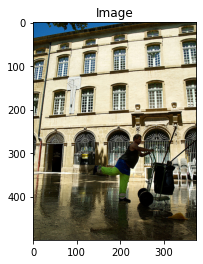

(50, 214)
Predicted Caption:-> drives goatee Young station hard and reflective The outdoors standing women climbing two rail tractor yard him women painting gloves sunlight sitting ropes beige caught by sitting large vest t-shirt tractor drives ropes other woman system giant cellphone shirt through Five midair photo stuffed dark-haired basket plays powder by 
Orignal Caption:-> A young woman with dark hair and wearing glasses is putting white powder on a cake using a sifter .,,,,, 


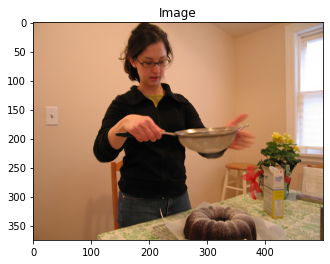

(50, 214)
Predicted Caption:-> drives young long yard stairs sunlight shaggy stands hands hats holding plays through brown Several system paintings protection up girl jacket clothes hanging leaning without are t-shirt sifter window lion glasses dark station 's an ballet climbing 's guitar small is dark-haired the playing giant camera end gun two 
Orignal Caption:-> Young man in jacket holding a toothpick with something on the end of it,,,,, 


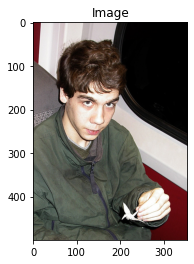

(50, 214)
Predicted Caption:-> an rainbow long <s> glasses it,,,,, .,,,,, metro t-shirt next tractor top without in <s> t-shirt ropes 's sunlight stands jumping way toward gun chair on hair glasses end clothes reflective alone Some place marketplace Several two in stairs something end shirts ear tattoo drives gray on concrete canvas 
Orignal Caption:-> Some women are standing in front of a bus with buildings behind it .,,,,, 


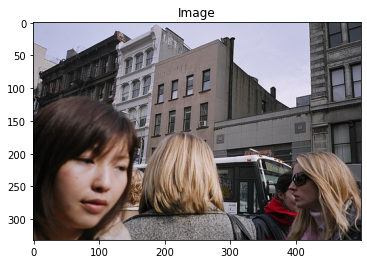

(50, 214)
Predicted Caption:-> drives wearing Two man glasses each up photo person ear brown-haired shaggy young in giant of against using back to gray climbing through on time front A sleeping chair back standing waste studio Young end small someone jump chair stuffed camera drives in two rail red beret 's with 
Orignal Caption:-> Two men ,,,,, 


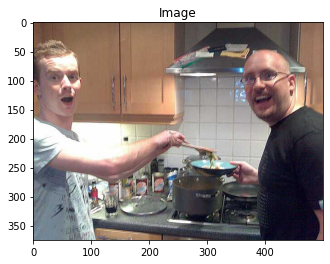

(24, 214)
Predicted Caption:-> in rainbow jump hat safety studio sleeping guitar it onto t-shirt fingerpaints dancing Some ears surrounded guys someone people chair shirts vest two 
Orignal Caption:-> Two people in the photo are playing the guitar and the other is poking at him .,,,,, 


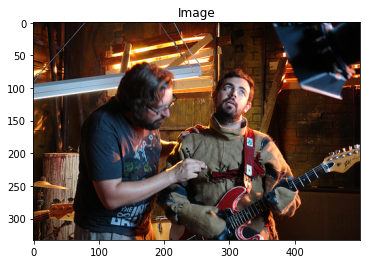

(50, 214)
Predicted Caption:-> in rainbow vest guitar beige rollerskates in glasses shirt t-shirt child cellphone standing Deere poking guitar ear small concrete raincoat women wearing end front top front beige spots person small something rail without painting foot surrounded onto gun giant lion basket two holding waste a to brown caught way 
Orignal Caption:-> An asian man wearing a black suit stands near a dark-haired woman and a brown-haired woman .,,,,, 


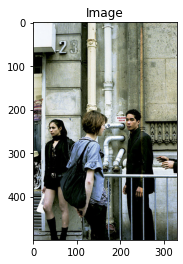

(50, 214)
Predicted Caption:-> on parking long crowd stairs dark it sifter child while 's it,,,,, ballet safety waste without rail 's basket her mid gun hats jump suit hair Five rail sitting hair dress with in rainbow pierced rainbow young the dark entry Three him photo up dark-haired beret stair safety Young 
Orignal Caption:-> Five ballet dancers caught mid jump in a dancing studio with sunlight coming through a window .,,,,, 


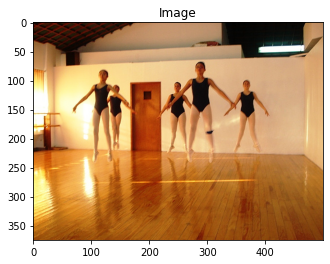

(50, 214)
Predicted Caption:-> drives beige sleeping John sits lion .,,,,, A hats group artists system guitar small alone ears stands cake ear The without two near by asian ropes shirt near bench through foot dark-haired clothes John up her large on fingerpaints large safety grips are with guys The grips bus woman 
Orignal Caption:-> A person in gray stands alone on a structure outdoors in the dark .,,,,, 


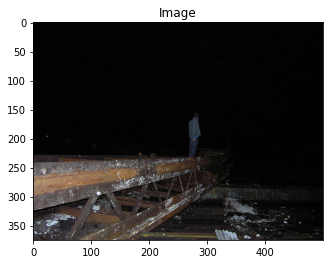

(50, 214)
Predicted Caption:-> in toward pierced Young shirt mid small group toothpick sifter it chair A mid up Some shirt jacket 's playing sits without safety hard onto 's caught sitting beige Germany ,,,,, Someone gun flag station artists sits dark glasses end waste front rail toward lion black leaning studio station 
Orignal Caption:-> Several men in hard hats are operating a giant pulley system .,,,,, 


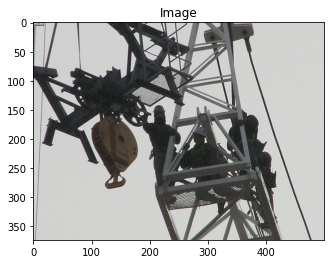

(50, 214)
Predicted Caption:-> drives goatee Young station hard and reflective The outdoors standing women climbing two rail tractor yard him women painting gloves sunlight sitting ropes beige caught by sitting large vest t-shirt tractor drives ropes other woman system giant cellphone shirt through Five midair photo stuffed dark-haired basket plays powder by 
Orignal Caption:-> A young woman with dark hair and wearing glasses is putting white powder on a cake using a sifter .,,,,, 


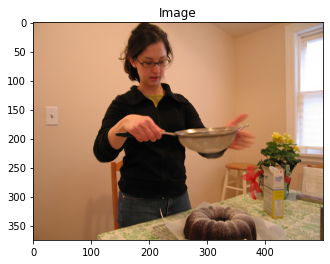

(50, 214)
Predicted Caption:-> drives waste the stuffed sits yard protection hats photo leaning Young her drives large up goatee metro top wearing guys .,,,,, while The it,,,,, over painting toward in gun toward group beret giant hats basket chair it bus talking midair basket protection onto young protection artists something white vest 
Orignal Caption:-> A man in a white t-shirt looks toward the camera surrounded by a crowd near a metro station .,,,,, 


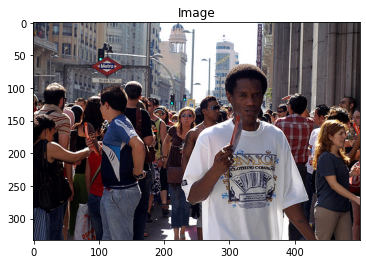

In [73]:
with tf.compat.v1.Session() as sess:
    sess.run(init)
    m = len(train_caption)
    for epoch in range(training_iters):
        total_cost = 0
        total_acc = 0
        for i in range(m):
            _, cst, acc = sess.run([optimizer, cost, accuracy], feed_dict = {x_caption:train_caption[i][:-1].A, x_inp:train[i:i+1], y:train_caption[i][1:].A})
            total_cost += cst
            total_acc += acc
        if (epoch + 1) % display_step == 0:
            print('After ', (epoch + 1), 'iterations: Cost = ', total_cost / m, 'and Accuracy: ', total_acc * 100/ m , '%' )
    print('Optimization finished!')
    print("Let's check")
    for tests in range(num_tests):
        image_num = random.randint(0, sample_size - 1)
        caption = sess.run(final_prediction, feed_dict = {x_inp:train[image_num:image_num + 1]})
        print(caption.shape)
        caption = np.argmax(caption[:-1], 1)
        capt = ''
        for i in caption:
            capt += rev_dict[i] + ' '
        print('Predicted Caption:->', capt)
        orig_cap = np.argmax(train_caption[image_num:image_num + 1][0][1:-1].A, 1)
        orignalcaption = ''
        for i in orig_cap:
            orignalcaption += rev_dict[i] + ' '
        print('Orignal Caption:->', orignalcaption)
        plt.imshow(real_images[image_num])
        plt.title('Image')
        plt.show()